(**Click the icon below to open this notebook in Colab**)

[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week08/notebook/demo.ipynb)

In [1]:
%%sh

ls -l work/2025-spring/week08/

total 4
-rw-r--r-- 1 jovyan users 476 Feb 25 03:21 README.md
drwxr-xr-x 4 jovyan users 128 Feb 26 21:58 data
drwxr-xr-x 3 root   root   96 Feb 25 03:19 notebook
drwxr-xr-x 2 jovyan users  64 Feb 25 03:19 pics


# Recap of Last Class

## Example - `prophet`

Prophet is an enhanced statistical tool because it extends traditional time series models with automated trend and seasonality detection, making it user-friendly and effective for business applications.

## Key Differences Between Holiday Effect and Seasonality  

| Feature            | Seasonality  | Holiday Effect |
|--------------------|-------------|---------------|
| **Definition**     | A **repeating pattern** that occurs at a fixed frequency (e.g., daily, weekly, yearly). | An impact on the time series caused by specific holidays or events. |
| **Regularity**     | **Strictly periodic** (e.g., weekly sales cycles, annual weather patterns). | **Not necessarily periodic** (holidays can fall on different weekdays each year). |
| **Examples**       | Increased ice cream sales in summer (yearly seasonality). Higher website traffic on weekends (weekly seasonality). | Lower stock market activity on Christmas. Higher online sales on Black Friday. |
| **Modeling in Prophet** | Modeled using a **Fourier series** to capture repeating cycles. | Modeled using **dummy variables** for specific dates, allowing deviations from normal patterns. |


In [2]:
import pandas as pd
from prophet import Prophet

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

Importing plotly failed. Interactive plots will not work.


In [3]:
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


The time series of the log daily page views for the Wikipedia page for Peyton Manning is used here
- https://facebook.github.io/prophet/docs/quick_start.html

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [5]:
m = Prophet(holidays=holidays)
m.fit(df)

future = m.make_future_dataframe(periods=365)
future.tail()

16:01:40 - cmdstanpy - INFO - Chain [1] start processing
16:01:41 - cmdstanpy - INFO - Chain [1] done processing


,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [6]:
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.217847,1.200633
2191,2014-02-03,1.898839,1.455819
2532,2015-01-11,1.217847,0.000000
2533,2015-01-12,1.898839,0.000000
2901,2016-01-17,1.217847,0.000000
2902,2016-01-18,1.898839,0.000000
2908,2016-01-24,1.217847,0.000000
2909,2016-01-25,1.898839,0.000000
2922,2016-02-07,1.217847,1.200633
2923,2016-02-08,1.898839,1.455819


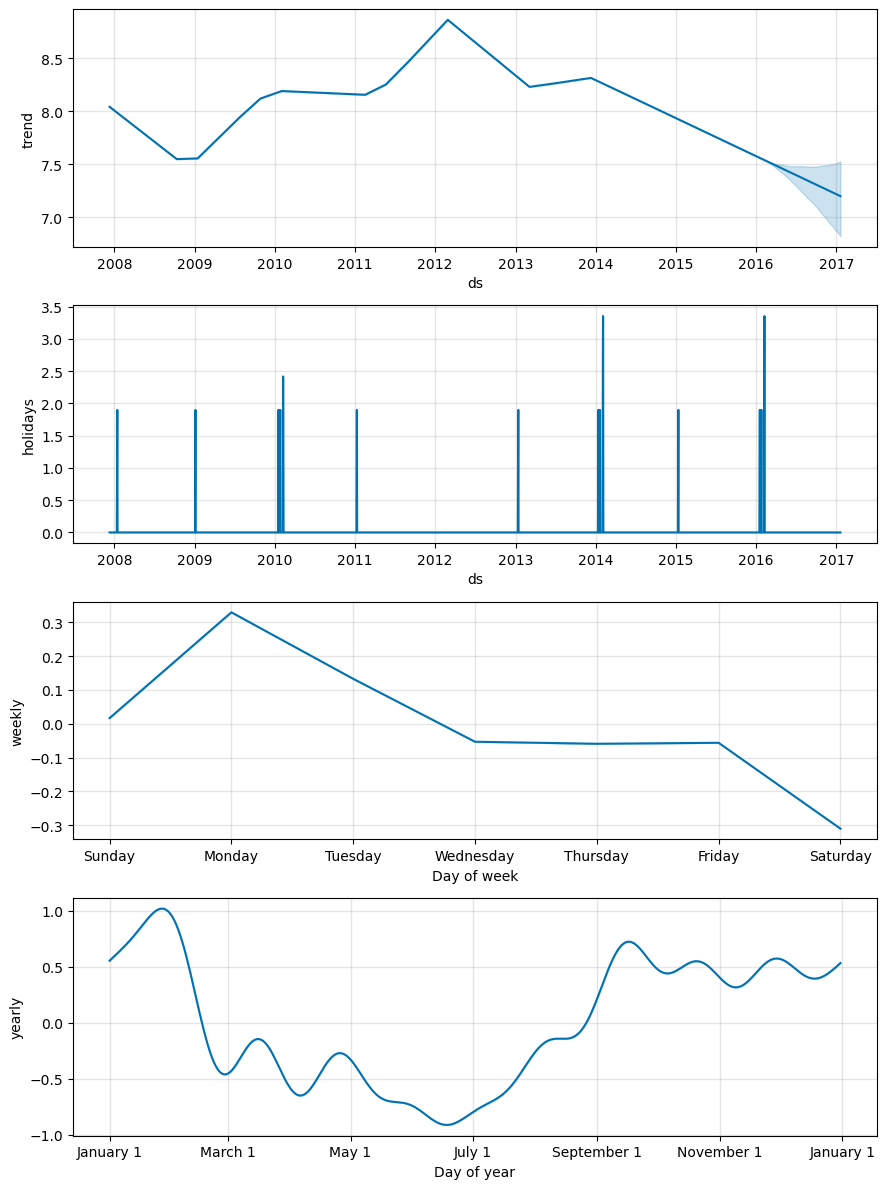

In [7]:
fig = m.plot_components(forecast)

## Example - `LSTM`

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# dataset_train = pd.read_csv('../data/Google_Stock_Price_Train.csv')
dataset_train = pd.read_csv('work/2025-spring/week08/data/Google_Stock_Price_Train.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [9]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set = dataset_train.iloc[:, 1:2].values
training_set_scaled = sc.fit_transform(training_set)

In [10]:
training_set_scaled.shape

(1258, 1)

In [11]:
training_set_scaled[0:10,:]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225],
       [0.0643277 ],
       [0.0585423 ],
       [0.06568569],
       [0.06109085],
       [0.06639259]])

In [12]:
X_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(1198, 60)

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [17]:
import tensorflow as tf

tf.__version__

2025-02-27 17:45:44.552842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.18.0'